## Integrating Structured and Unstructured Data

In [103]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


### Reading Sanitized BOM (Bill of Materials) data

In [104]:
# BOM file
import pandas as pd

bom_df = pd.read_csv('../data/bom_sample_brakes.csv')
bom_df.head(3)

,Part Number,Design Level Description,Category
0,Part Number - 1,DSC BRK WHL,Front Rotor and Shield
1,Part Number - 2,DSC BRK WHL,Front Rotor and Shield
2,Part Number - 3,DSC BRK WHL,Front Rotor and Shield


### Unique Part Categories

In [105]:
cat_set = bom_df.Category.unique()

In [106]:
len(bom_df),  len(bom_df['Category'].unique()), len(bom_df['Design Level Description'].unique())

(1135, 14, 138)

In [107]:
cat_set

array(['Front Rotor and Shield',
       'Front Caliper, Anchor and Attaching Components',
       'Rear Caliper, Anchor and Attaching Components',
       'Brake Lines and Hoses', 'Master Cylinder and Reservoir', 'Pedals',
       'Rear Rotor and Shield', 'Parking Brake Controls',
       'Brake Controls Hardware', 'Air Brake Tubes and Hoses',
       'Vacuum Booster', '060101', 'Air Brake Valves', 'Brake Fluid'],
      dtype=object)

### Wiki Entities Vocabulary

In [108]:
cpsc_vocab = set()
for word in cat_set:
    cpsc_vocab.update(word.split())
cpsc_vocab.remove("and")
list(cpsc_vocab)[:12]

['Anchor',
 'Fluid',
 'Vacuum',
 'Caliper,',
 'Front',
 'Valves',
 'Brake',
 'Lines',
 'Air',
 'Rear',
 'Cylinder',
 '060101']

### Semantic Embeddings of Part Categories

In [109]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

In [110]:
# (Ref: https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1)
sentence_embeddings = model.encode(cat_set)
sentence_embeddings.shape

(14, 768)

In [111]:
wiki_brk_df = pd.read_csv('../data/wiki_brake_full_entities3.csv')
wiki_brk_df.head()

,Unnamed: 0,Sent,Len,wiki_entities,wiki_positions
0,0,A brake is a mechanical device that inhibits m...,16,"['Machine', 'Energy']","[[(13, 22), (13, 29)], [(65, 70)]]"
1,1,A brake is used for slowing or stopping a movi...,26,"['Brake', 'Axle', 'Friction']","[[(2, 6), (87, 91)], [(65, 68)], [(137, 144)]]"
2,2,Most brakes commonly use friction between two ...,30,"['Friction', 'Kinetic energy', 'Heat']","[[(25, 32)], [(87, 93), (87, 100), (95, 100), ..."
3,3,"For example, regenerative braking converts muc...",19,['Regenerative brake'],"[[(13, 24), (13, 32)]]"
4,4,Other methods convert kinetic energy into pote...,18,"['Kinetic energy', 'Potential energy']","[[(22, 28), (22, 35), (30, 35), (52, 57)], [(4..."


In [112]:
wiki_brk_df = wiki_brk_df.dropna()

In [113]:
ent_enc.shape

(1, 768)

### Semantic Embedding of Wiki Sentences and Most similar Part Category

In [114]:
from tqdm.notebook import tqdm

ent_cat = []

for ent_set in tqdm(wiki_brk_df.dropna().Sent):
    if len(ent_set)<1:
        continue
    ent_encoding = model.encode(ent_set).reshape(1, -1)
    cosim = cosine_similarity(
        ent_encoding, sentence_embeddings)
    max_sim = np.argmax(cosim, axis=1)
    ent_cat.append(cat_set[max_sim[0]])
    #print(np.max(similarity_matrix))

  0%|          | 0/9581 [00:00<?, ?it/s]

In [115]:
ent_cat[:10]

['Brake Controls Hardware',
 'Brake Controls Hardware',
 'Brake Controls Hardware',
 'Brake Controls Hardware',
 'Brake Controls Hardware',
 'Brake Controls Hardware',
 'Rear Rotor and Shield',
 'Brake Controls Hardware',
 'Rear Rotor and Shield',
 'Brake Fluid']

### Inserting the Entity Category in Wiki Entity dataframe

In [133]:
wiki_brk_df['category'] = ent_cat
wiki_brk_df.head()

,Unnamed: 0,Sent,Len,wiki_entities,wiki_positions,category
0,0,A brake is a mechanical device that inhibits m...,16,"['Machine', 'Energy']","[[(13, 22), (13, 29)], [(65, 70)]]",Brake Controls Hardware
1,1,A brake is used for slowing or stopping a movi...,26,"['Brake', 'Axle', 'Friction']","[[(2, 6), (87, 91)], [(65, 68)], [(137, 144)]]",Brake Controls Hardware
2,2,Most brakes commonly use friction between two ...,30,"['Friction', 'Kinetic energy', 'Heat']","[[(25, 32)], [(87, 93), (87, 100), (95, 100), ...",Brake Controls Hardware
3,3,"For example, regenerative braking converts muc...",19,['Regenerative brake'],"[[(13, 24), (13, 32)]]",Brake Controls Hardware
4,4,Other methods convert kinetic energy into pote...,18,"['Kinetic energy', 'Potential energy']","[[(22, 28), (22, 35), (30, 35), (52, 57)], [(4...",Brake Controls Hardware


### Part Category Distribution across Wiki Entities

In [134]:
wiki_brk_df.category.value_counts()

Brake Controls Hardware                           3652
Brake Lines and Hoses                             1149
Brake Fluid                                       1067
Parking Brake Controls                             815
Air Brake Tubes and Hoses                          680
060101                                             337
Front Caliper, Anchor and Attaching Components     286
Rear Caliper, Anchor and Attaching Components      281
Master Cylinder and Reservoir                      246
Vacuum Booster                                     234
Air Brake Valves                                   228
Pedals                                             207
Rear Rotor and Shield                              204
Front Rotor and Shield                             195
Name: category, dtype: int64

<AxesSubplot:>

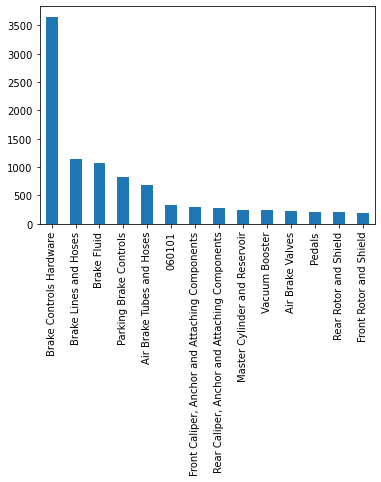

In [135]:
wiki_brk_df.category.value_counts().plot(kind='bar')

In [136]:
wiki_brk_df.head()

,Unnamed: 0,Sent,Len,wiki_entities,wiki_positions,category
0,0,A brake is a mechanical device that inhibits m...,16,"['Machine', 'Energy']","[[(13, 22), (13, 29)], [(65, 70)]]",Brake Controls Hardware
1,1,A brake is used for slowing or stopping a movi...,26,"['Brake', 'Axle', 'Friction']","[[(2, 6), (87, 91)], [(65, 68)], [(137, 144)]]",Brake Controls Hardware
2,2,Most brakes commonly use friction between two ...,30,"['Friction', 'Kinetic energy', 'Heat']","[[(25, 32)], [(87, 93), (87, 100), (95, 100), ...",Brake Controls Hardware
3,3,"For example, regenerative braking converts muc...",19,['Regenerative brake'],"[[(13, 24), (13, 32)]]",Brake Controls Hardware
4,4,Other methods convert kinetic energy into pote...,18,"['Kinetic energy', 'Potential energy']","[[(22, 28), (22, 35), (30, 35), (52, 57)], [(4...",Brake Controls Hardware


In [137]:
import ast
entity_set = set([entity for entities in wiki_brk_df.wiki_entities for entity in ast.literal_eval(entities)])
print("Number of unique entities: ", len(entity_set))

Number of unique entities:  2544


In [138]:
entity_list = [entity for entities in wiki_brk_df.wiki_entities for entity in ast.literal_eval(entities)]
len(entity_list)

23814

### How many categories each entities are associated to...?

In [139]:
# Same entity in different sentences can get mapped to different Categories
# Here we are counting occurrences of Categories for each entity
import ast
from tqdm.notebook import tqdm
from collections import defaultdict

entity_dict={}

for idx, row in tqdm(wiki_brk_df.iterrows()):
    
    # Iterate over every permutation pair of entities
    entities = ast.literal_eval(row['wiki_entities'])
    cat = row.category
    
    for entity in entities:
        # add entity to the dict if not already there
        if entity not in entity_dict.keys():
            entity_dict[entity] = {}
        
        # initialize cpsc count if not there else increment
        subdict = entity_dict[entity]
        if cat in subdict.keys():
            subdict[cat] += 1
        else:
            subdict[cat] = 1
len(entity_dict)

0it [00:00, ?it/s]

2544

### Wiki Entity Vs. Assigned Category Matrix

In [140]:
# Option 1 - identify count vectors for each entity in all CPSCs
ent_cat_df = pd.DataFrame.from_dict(entity_dict, orient="columns").fillna(0)
ent_cat_df

,Machine,Energy,Brake,Axle,Friction,Kinetic energy,Heat,Regenerative brake,Potential energy,Eddy current brake,...,Double layer (surface science),New European Driving Cycle,Valencian Community,Shinichiro Koyama,Usenet newsgroup,The Hours (novel),Morand Racing,Go-Ahead Group,Dewar Trophy,Royal Automobile Club
Brake Controls Hardware,30.0,25.0,1133,60.0,119.0,25.0,36.0,57.0,2.0,23.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
Brake Fluid,8.0,34.0,266,2.0,100.0,16.0,34.0,6.0,3.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brake Lines and Hoses,10.0,0.0,365,7.0,67.0,6.0,18.0,35.0,0.0,10.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Air Brake Tubes and Hoses,1.0,5.0,127,0.0,25.0,17.0,27.0,15.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Parking Brake Controls,0.0,5.0,133,4.0,13.0,13.0,5.0,2.0,0.0,2.0,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0
Rear Rotor and Shield,0.0,4.0,28,0.0,3.0,13.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vacuum Booster,0.0,3.0,8,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Master Cylinder and Reservoir,0.0,1.0,12,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Air Brake Valves,0.0,1.0,54,0.0,5.0,3.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Front Caliper, Anchor and Attaching Components",0.0,0.0,13,2.0,6.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
# Option 2 - identify the most frequently occurring Category for each entity
ent_cat_dict = {}
for key in entity_dict.keys():
    cats = entity_dict[key]
    cat = sorted(cats, key=cats.get, reverse=True)[:5]
    ent_cat_dict[key] = cat
# ent_cat_dict


In [143]:
ent_cat_df2 = pd.DataFrame.from_dict(ent_cat_dict, orient='index').stack().reset_index()

ent_cat_df2=ent_cat_df2.rename(columns={0:'target_term', 'level_0':'source_term'})
ent_cat_df2['relation'] = 'related to'
ent_cat_df2 = ent_cat_df2[['source_term', 'target_term', 'relation']]
ent_cat_df2.head()

,source_term,target_term,relation
0,Machine,Brake Controls Hardware,related to
1,Machine,Brake Lines and Hoses,related to
2,Machine,Brake Fluid,related to
3,Machine,Air Brake Tubes and Hoses,related to
4,Energy,Brake Fluid,related to


In [144]:
len(ent_cat_df2)

4418

### Wiki entity type

In [157]:
entity_type_df = pd.read_csv('../data/wiki_entity_vocab.csv')

entity_vocab = {}
for idx,ent_type in entity_type_df.iterrows():
    entity = ent_type.entity
    etype = ent_type.type
    entity_vocab[entity]=etype
len(entity_vocab)

887

In [164]:
ent_cat_df2['source_type'] = ent_cat_df2.source_term.apply(lambda entity: entity_vocab[entity] if entity in entity_vocab.keys() else 'unknown')
ent_cat_df2['target_type'] = 'part category'
ent_cat_df2.head()

,source_term,target_term,relation,source_type,target_type
0,Machine,Brake Controls Hardware,related to,product,part category
1,Machine,Brake Lines and Hoses,related to,product,part category
2,Machine,Brake Fluid,related to,product,part category
3,Machine,Air Brake Tubes and Hoses,related to,product,part category
4,Energy,Brake Fluid,related to,parameter,part category


### Preparing BOM data for Network Graph

In [165]:
# BOM data preparation for graph
bom_grph = bom_df.copy()

bom_grph['source_term'] = bom_grph['Design Level Description']+'_'+bom_grph['Part Number']

bom_grph['target_term'] = bom_grph['Category'].apply(lambda x: re.sub("[\d\-]", "", x).strip())
bom_grph['relation'] = 'belongs to'
bom_grph['source_type'] = 'ebom'
bom_grph['target_type'] = 'part category'
bom_grph = bom_grph.drop_duplicates(subset=['source_term'], keep='first')
bom_grph = bom_grph[['source_term', 'target_term', 'relation', 'source_type', 'target_type']]
bom_grph[['source_term', 'target_term', 'relation', 'source_type', 'target_type']].head()

,source_term,target_term,relation,source_type,target_type
0,DSC BRK WHL_Part Number - 1,Front Rotor and Shield,belongs to,ebom,part category
1,DSC BRK WHL_Part Number - 2,Front Rotor and Shield,belongs to,ebom,part category
2,DSC BRK WHL_Part Number - 3,Front Rotor and Shield,belongs to,ebom,part category
3,DSC BRK WHL_Part Number - 4,Front Rotor and Shield,belongs to,ebom,part category
4,DSC BRK WHL_Part Number - 5,Front Rotor and Shield,belongs to,ebom,part category


### Combining BOM and Wiki data into one dataframe

In [166]:
bom_grph = bom_grph.append(ent_cat_df2)
len(bom_grph)

5523

In [167]:
bom_grph.head()

,source_term,target_term,relation,source_type,target_type
0,DSC BRK WHL_Part Number - 1,Front Rotor and Shield,belongs to,ebom,part category
1,DSC BRK WHL_Part Number - 2,Front Rotor and Shield,belongs to,ebom,part category
2,DSC BRK WHL_Part Number - 3,Front Rotor and Shield,belongs to,ebom,part category
3,DSC BRK WHL_Part Number - 4,Front Rotor and Shield,belongs to,ebom,part category
4,DSC BRK WHL_Part Number - 5,Front Rotor and Shield,belongs to,ebom,part category


In [169]:
# bom_grph.to_csv('../data/wiki_bom.csv')

In [150]:
bom_grph[(bom_grph.target_term=='Pedals') | (bom_grph.target_term=='Front Rotor and Shield')]

,source_term,target_term,relation
0,DSC BRK WHL_Part Number - 1,Front Rotor and Shield,belongs to
1,DSC BRK WHL_Part Number - 2,Front Rotor and Shield,belongs to
2,DSC BRK WHL_Part Number - 3,Front Rotor and Shield,belongs to
3,DSC BRK WHL_Part Number - 4,Front Rotor and Shield,belongs to
4,DSC BRK WHL_Part Number - 5,Front Rotor and Shield,belongs to
...,...,...,...
4301,Civilian,Front Rotor and Shield,related to
4302,Folland Gnat,Front Rotor and Shield,related to
4384,Brussels,Front Rotor and Shield,related to
4413,The Hours (novel),Front Rotor and Shield,related to


### Visualization of integrated Data

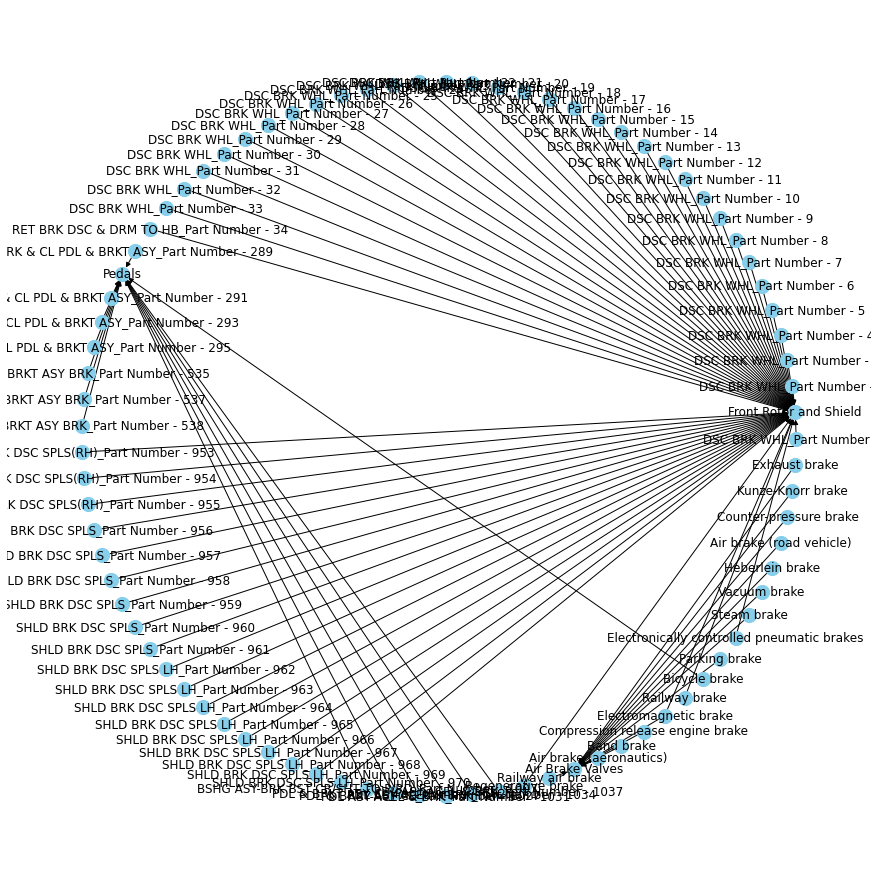

In [175]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(bom_grph[
    ((bom_grph.target_term=='Pedals') | (bom_grph.target_term=='Front Rotor and Shield') |
    (bom_grph.target_term=='Air Brake Valves')) & 
    (bom_grph.relation.isin(['related to', 'belongs to'])) &
    ((bom_grph.source_term.str.contains('brake')) | (bom_grph.source_term.str.contains('BRK')))
], "source_term", "target_term", # [kg_df2['relation']=="has part"]
                          edge_attr=True, create_using=nx.MultiDiGraph())

figure(figsize=(12, 12))
pos=nx.spring_layout(G, k=0.8)
# nx.draw_shell(G, with_labels=True)

# random_state_index is incorrect --> I had the problem with decorator 5.0.6, but upgrading to 5.1 fixed it
nx.draw_circular(G, with_labels=True, node_color='skyblue', node_size=200, edge_cmap=plt.cm.Blues)
plt.show()

**The above visualization shows all the BOM Parts as well as the Requirement Entities associated to the selected Part categories.**

## Thank You...!!